# Exploring Time Series Forecasting with LSTMs

## Research Questions

In this notebook I will explore applying deep learning to time series forecasting scenarios within the stock market. I will explore a handful of stocks within the S&P500 and the S&P500 index itself. In all cases we'll be predicting the Closing price using a combination of endogenous and exogenus features. We will use a simple 'Naive' forecast as the baseline for comparing our more complex LSTM implementation.
<br>
1. Forecast the next 1 hour of closing prices based on the previous 8 hours (minute resolution). This will be created with (max) 15 features, 480 timesteps backward and 60 timesteps forward.
2. Next day of closing prices based on previous week (hour resoultion). This will be created with (max) 15 features, 168 timesteps backward and 24 timesteps forward.
3. Next month of closing prices based on the previous month (daily resolution). This will be created with (max) 15 features, 30 timesteps backward and 30 timesteps forward.
<br>

We will begin with Question 3 as it poses the lowest computational overhead due to the lowest amount of columns and rows being required.

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn import metrics
import tqdm
%matplotlib inline

### Load the data
#### Minute Resolution Data

In [2]:
if False:

    keep_col = list(range(1,18))

    df_min = pd.read_csv('Clean Data/ECL_Clean_Minute.csv', 
                         infer_datetime_format=True,
                         parse_dates=['Timestamp'], 
                         index_col=['Timestamp'], 
                         usecols=keep_col,
                         date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))
    #df_min.dtypes
    #df_min.drop(df_min.columns[0], axis=1, inplace=True)
    #print (df_min.columns)
    print (df_min.shape)
    df_min.head(5)

#### Hourly Resolution Data

In [3]:
if False:

    keep_col = list(range(1,18))

    df_hour = pd.read_csv('Clean Data/ECL_Clean_Hour.csv', 
                         infer_datetime_format=True,
                         parse_dates=['Timestamp'], 
                         index_col=['Timestamp'],
                         usecols = keep_col,
                         date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    #df_min.dtypes
    print (df_hour.shape)
    df_hour.head(5)

#### Daily Resolution Data

In [4]:
if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('Clean Data/ECL_Clean_Day.csv', 
                         infer_datetime_format=True,
                         parse_dates=['Timestamp'], 
                         index_col=['Timestamp'],
                         usecols = keep_col,
                         date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    #df_min.dtypes
    print (df_day.shape)
    #df_day.head(5)

(5031, 16)


### Question 3

*Predict the next month of closing prices based on the previous month (daily resolution). This will be created with (max) 15 features, 30 timesteps backward and 30 timesteps forward.*

Plan of attack:
* Create the Train/Test data
* Create a Baseline model
* Play around with the LSTM
* Report the Results wrt Resolution, Model Choice and Benchmark Model from Proposal

#### Build the Baseline

In [1]:
# create 10 years of data from 2019 - 2010
day_data = df_day[df_day.index >= '2010-01-01']

#split 7 years train, 3 years test
day_train = day_data[day_data.index <= '2017-01-01']
day_test = day_data[day_data.index >= '2017-01-01']

NameError: name 'df_day' is not defined

In [6]:
base_train = day_train['Close'] 
base_test = day_test['Close']

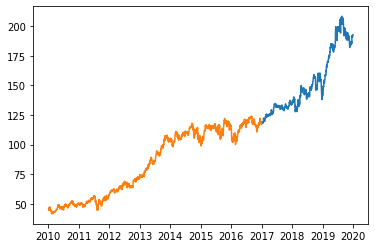

In [7]:
plt.plot(base_test)
plt.plot(base_train)
plt.show()

### Baseline Model

Please see ARIMA Baseline.ipynb for the details on the baseline model created for this project.

### Vanilla LSTM

I'll now initialize a vanilla LSTM to conduct the same forecast task. We'll need to add in some additional steps to the Baseline model above.

1. Split the data for Train/Test
2. Transform the data as a Supervised Learning problem
3. Reshape the data to pass into the LSTM
4. Initialize the LSTM
5. Fit the LSTM using the Training data
6. Use the model to make a single prediction per step
7. Add the step to the training set
8. Repeat 1 - 7
9. Plot the Results

Following Ex. 9.4.1, Univariate Multistep Forecasting with LSTM

In [23]:
# Multi-Step Data Preparation

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 30, 30

# split into samples
X_train, y_train = split_sequence(base_train.values, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(base_test.values, n_steps_in, n_steps_out) #length must be > n_in + n_out

# summarize the data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1703, 30) (1703, 30) (695, 30) (695, 30)


In [24]:
#Load required Keras modules

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
#print (X_train.shape)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
#print (X_test.shape)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1, shuffle=False)

# demonstrate prediction
x_input = X_test[0]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print('\nTest Prediction for X_test[0]\n',yhat)

Using TensorFlow backend.
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jacobscottant


Train on 1703 samples, validate on 695 samples
Epoch 1/20
1703/1703 [==============================] - 6s 4ms/step - loss: 5872.9773 - val_loss: 7418.6100
Epoch 2/20
1703/1703 [==============================] - 5s 3ms/step - loss: 1577.6426 - val_loss: 1447.6097
Epoch 3/20
1703/1703 [==============================] - 5s 3ms/step - loss: 123.1667 - val_loss: 152.1297
Epoch 4/20
1703/1703 [==============================] - 6s 4ms/step - loss: 42.1707 - val_loss: 82.6465
Epoch 5/20
1703/1703 [==============================] - 6s 3ms/step - loss: 34.7755 - val_loss: 81.6987
Epoch 6/20
1703/1703 [==============================] - 6s 4ms/step - loss: 31.0479 - val_loss: 78.2617
Epoch 7/20
1703/1703 [==============================] - 5s 3ms/step - loss: 29.2683 - val_loss: 81.9877
Epoch 8/20
1703/1703 [==============================] - 5s 3ms/step - loss: 31.0821 - val_loss: 74.7305
Epoch 9/20
1703/1703 [==============================] - 5s 3ms/step - loss: 29.1918 - val_loss: 72.7367
Epoch 

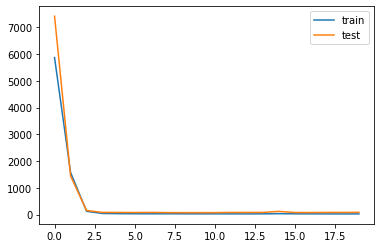

In [25]:
#Plot the Training and Validation Loss

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### LSTM Training Results
* Seems to be fine
* Looks OK
* What else can I do?

#### Talos Grid Search Results
* Something
* Something else
* More
* Thoughts
* Table of best hyper-parameters

In [26]:
#Walk the model forward WITHOUT re-fit at each step
n_steps_in, n_steps_out = 30, 30
n_features = 1
step = 30
predictions = list()
pred_dict = dict()
errors = list()
count = 0

#This first iteration captures a prediction for the first 30 days of the Test Period. ie I want to predict X_test[0]

#last 30 timesteps before start of X_test
x_input = y_train[-1]

#reshape for LSTM
x_input = x_input.reshape((1, n_steps_in, n_features))

#make a prediction
yhat = model.predict(x_input, verbose=0)

#append the prediction to the list
predictions.append(yhat[0])

#create a dataframe
res = pd.DataFrame(list(range(1,31)), columns=['Day'])

#append results to dataframe
res['Pred'] = yhat[0]

#add dataframe to dict
pred_dict[count] = res

#calculate errors
mae = metrics.mean_absolute_error(X_test[0],yhat[0][0:len(X_test)])
rmse = metrics.mean_squared_error(X_test[0],yhat[0][0:len(X_test)])

#append error to list
err = [count+1, mae, rmse]
errors.append(err)

#Main Loop to loop through the rest of the steps
for i in np.arange(0, len(X_test), step):
    
    #last 30 timesteps before start of X_test
    x_input = X_test[i]
    
    #reshape for LSTM
    x_input = x_input.reshape((1, n_steps_in, n_features))
    
    #make a prediction
    yhat = model.predict(x_input, verbose=0)
    
    #append the prediction to the list
    predictions.append(yhat[0])
    
    #create a dataframe
    res = pd.DataFrame(list(range(1,31)), columns=['Day'])
    
    #append results to dataframe
    res['Pred'] = yhat[0]
    
    #add dataframe to dict
    pred_dict[count] = res
    
    #calculate errors
    mae = metrics.mean_absolute_error(y_test[i],yhat[0][0:len(y_test[i])])
    rmse = metrics.mean_squared_error(y_test[i],yhat[0][0:len(y_test[i])])
    
    #append error to list
    err = [count+1, mae, rmse]
    errors.append(err)
    
    #print update
    #print('Iteration:',count+1)
    #print('MAE:',mae)
    #print('RMSE:',rmse)
    
    #increase counter
    count += 1   

In [27]:
#Check output shapes

#predictions
#error
#pred_dict

In [28]:
#unravel the array to plot the prediction over the actual

pred = np.concatenate(predictions).ravel().tolist()
#len(pred)

In [29]:
results = pd.DataFrame(base_test)
results = results[:len(pred)]
#len(results)
results['Pred'] = pred[:len(results)]

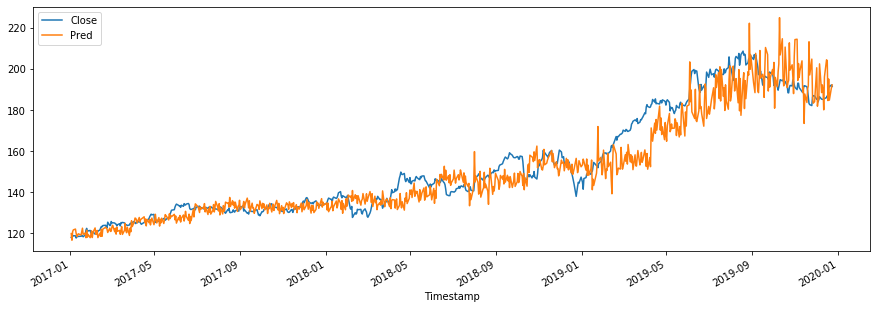

In [30]:
results.plot(figsize=(15,5))

In [31]:
#Total Error for the Walk Fowrard
total_MAE = metrics.mean_absolute_error(results['Close'], results['Pred'])
total_RMSE = metrics.mean_squared_error(results['Close'], results['Pred'])

print('Aggregate Error for the Walk Forward Validation:')
print('Mean Absolute Error:',total_MAE)
print('Mean Squared Error:',total_RMSE)

Aggregate Error for the Walk Forward Validation:
Mean Absolute Error: 6.30990051459961
Mean Squared Error: 75.99564454561103


In [32]:
results.corr(method='pearson')

,Close,Pred
Close,1.000000,0.945734
Pred,0.945734,1.000000


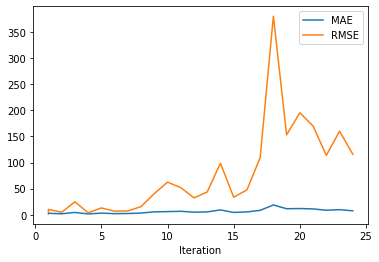

In [33]:
b = pd.DataFrame.from_records(errors, columns=['Iteration', 'MAE', 'RMSE'])
b.plot(x='Iteration', y=['MAE','RMSE'])

In [34]:
#combine all the dfs in the pred_dict dictionary

combined = pd.concat(pred_dict.values(), ignore_index=True)
#combined = combined[0:len(pred)]
combined['Actual'] = base_test.values[0:len(combined)]
#len(combined)

In [35]:
#calculate our the error by day in the forecast

error_by_day = list()

for i in range(1,31):
    df = combined[combined.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    error_by_day.append(error)

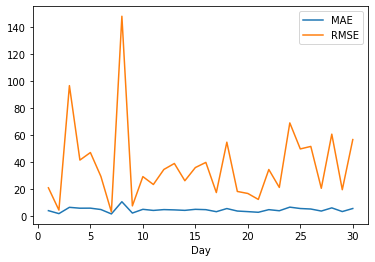

In [36]:
a = pd.DataFrame.from_records(error_by_day, columns=['Day', 'MAE', 'RMSE'])
a.plot(x='Day', y=['MAE','RMSE'])

Hmmm. Model performance is garbage, especially towards the end. I believe I need to retrain at each step.
* Other thing
* Other thing
* Other things

#### Walk Forward with Re-Fit at each step and single prediction at each step
* Describe below
* One
* Two
* Three

In [37]:
#Define the LSTM Model in a function to be called in the loop below

def LSTM_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    return model

In [38]:
#Walk Forward with re-fit at each step and single prediction for each refit

#Inputs for Walk-Forward
X = day_data['Close']
n_train = len(base_train)
n_records = len(base_train)+len(base_test)
step = 30
predictions = list()
pred_dict = dict()
errors = list()
count = 0

#Main Loop
for i in tqdm.tqdm_notebook(np.arange(n_train, n_records, step)):
    #split data
    train, test = X[0:i], X[n_train:]
    Xtest = X[i:]
    #rearrange to supervised
    X_train, y_train = split_sequence(train.values, n_steps_in, n_steps_out)
    X_test, y_test = split_sequence(test.values, n_steps_in, n_steps_out)
    Xtest,ytest = split_sequence(test.values, n_steps_in, n_steps_out)
    #reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    #create model
    model = LSTM_model()
    #fit the model
    model_fit = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=0, shuffle=False)
    #create the forecast  
    x_input = y_train[-1]
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0) 
    #save the output
    predictions.append(yhat[0])
    #create output df
    res = pd.DataFrame(list(range(1,31)), columns=['Day'])
    res['Pred'] = yhat[0]
    pred_dict[count] = res
    #calcuate error, last iteration is always diff shape we'll just calculate what we have
    mae = metrics.mean_absolute_error(Xtest[0],yhat[0])
    rmse = metrics.mean_squared_error(Xtest[0],yhat[0])
    #append error to list
    err = [count+1, mae, rmse]
    errors.append(err)
    #print update
    print('Step:',count+1)
    print('MAE:',mae)
    print('RMSE:',rmse)
    print('\n')
    #increase counter
    count += 1

Step: 1
MAE: 2.0845584513346354
RMSE: 6.401879180397866


Step: 2
MAE: 2.0555028584798163
RMSE: 6.010516976513686


Step: 3
MAE: 3.885844512939452
RMSE: 21.917233034862296


Step: 4
MAE: 8.183364003499348
RMSE: 72.70019903021499


Step: 5
MAE: 8.304723490397134
RMSE: 84.2969332278065


Step: 6
MAE: 15.940883789062498
RMSE: 257.70658419275594


Step: 7
MAE: 12.589865091959636
RMSE: 231.99069443515407


Step: 8
MAE: 11.694537251790363
RMSE: 141.35777742543598


Step: 9
MAE: 13.22486104329427
RMSE: 178.53074329643138


Step: 10
MAE: 16.226940307617188
RMSE: 267.14126808504636


Step: 11
MAE: 11.235175252278646
RMSE: 166.7231167145992


Step: 12
MAE: 18.378230183919275
RMSE: 343.6137643402429


Step: 13
MAE: 26.54652852376302
RMSE: 713.4196930714223


Step: 14
MAE: 24.667288614908852
RMSE: 613.612921493462


Step: 15
MAE: 25.6621462097168
RMSE: 844.8301029570995


Step: 16
MAE: 39.21644868977865
RMSE: 2122.465825227207


Step: 17
MAE: 18.96289484659831
RMSE: 508.10372022830956


Step: 18
M

In [39]:
#predictions

In [40]:
#unravel the array to plot the prediction over the actual
pred = np.concatenate(predictions).ravel().tolist()
#len(pred)

In [41]:
results = pd.DataFrame(base_test[30:])
results = results[:len(pred)]
#len(results)
results['Pred'] = pred[:len(results)]

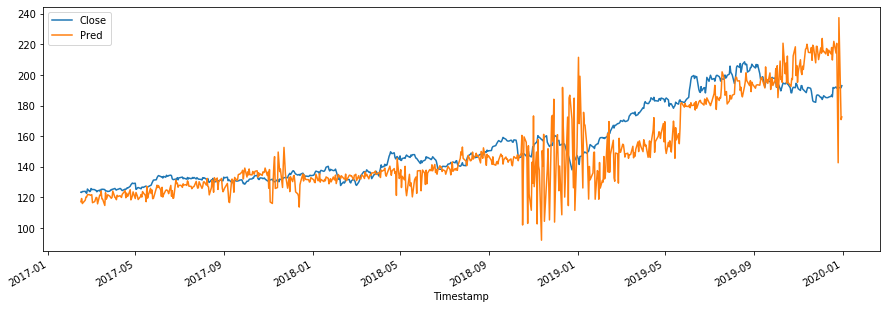

In [42]:
results.plot(figsize=(15,5))

In [43]:
#Total Error for the Walk Fowrard
total_MAE = metrics.mean_absolute_error(results['Close'], results['Pred'])
total_RMSE = metrics.mean_squared_error(results['Close'], results['Pred'])

print('Aggregate Error for the Walk Forward Validation:')
print('Mean Absolute Error:',total_MAE)
print('Mean Squared Error:',total_RMSE)

Aggregate Error for the Walk Forward Validation:
Mean Absolute Error: 11.40209261027805
Mean Squared Error: 246.86725214088798


In [44]:
results.corr(method='pearson')

,Close,Pred
Close,1.000000,0.854541
Pred,0.854541,1.000000


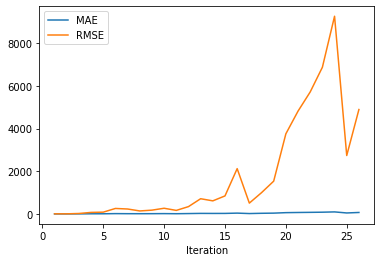

In [45]:
b = pd.DataFrame.from_records(errors, columns=['Iteration', 'MAE', 'RMSE'])
b.plot(x='Iteration', y=['MAE','RMSE'])

In [46]:
#combine all the dfs in the pred_dict dictionary

combined = pd.concat(pred_dict.values(), ignore_index=True)
combined = combined[0:len(base_test.values)]
combined['Actual'] = base_test.values[0:len(combined)]
#len(combined)
#len(base_test.values)

In [47]:
#calculate our the error by day in the forecast

error_by_day = list()

for i in range(1,31):
    df = combined[combined.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE, err_MSE]
    error_by_day.append(error)

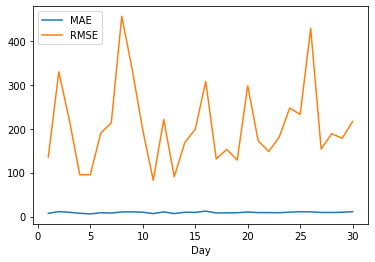

In [48]:
a = pd.DataFrame.from_records(error_by_day, columns=['Day', 'MAE', 'RMSE'])
a.plot(x='Day', y=['MAE','RMSE'])

#### Results
* One
* Two
* Three

#### Walk Foward with re-fit at each step and prediction of entire test set at each step

In [49]:
#Walk Forward with re-fit at each step and 23 predictions for each refit

#Inputs for Walk-Forward
X = day_data['Close'] #[:1000]
n_train = len(base_train) #800
n_records = len(base_train)+len(base_test) #len(X)
step = 30 #50
n_steps_in = 30 #10
n_steps_out = 30 #10
n_features = 1

pred_dict = dict()
errors = list()
count = 0

#Main Loop
for i in tqdm.tqdm_notebook(np.arange(n_train, n_records, step)):
    #split data
    train, test = X[0:i], X[n_train:]
    
    #rearrange to supervised
    X_train, y_train = split_sequence(train.values, n_steps_in, n_steps_out)
    X_test, y_test = split_sequence(test.values, n_steps_in, n_steps_out)
    
    #reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    
    #create model
    model = LSTM_model()
    
    #fit the model
    model_fit = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=0, shuffle=False)
    
    #create the prediction counter for X_test loop
    time_count = 0
    
    #reset list for all the predictions
    predictions = list()
    
    #reset dict to catch all the output dfs (res)
    fore_dict = dict()
    
    #predict loop for each sample in X_test
    for t in np.arange(0, len(X_test), 1):
        x_input = X_test[t]
        x_input = x_input.reshape((1, n_steps_in, n_features))
        yhat = model.predict(x_input, verbose=0)
        predictions.append(yhat[0])
        
        #create output df
        res = pd.DataFrame(list(range(1,n_steps_out+1)), columns=['Day'])
        res['Pred'] = yhat[0]
        fore_dict[time_count] = res
        #calcuate error, last iteration is always diff shape we'll just calculate what we have
        #mae = metrics.mean_absolute_error(y_test[t],yhat[0])
        #rmse = metrics.mean_squared_error(y_test[t],yhat[0])
        time_count += 1
    
    pred_dict[count] = fore_dict
    #calculate error for all predictions (X_test)
    mae = metrics.mean_absolute_error(y_test, predictions)
    rmse = metrics.mean_squared_error(y_test, predictions)
    err = [count+1, mae, rmse]
    errors.append(err)
    
    #print update
    print('Step:',count+1)
    print('MAE:',mae)
    print('RMSE:',rmse)
    print('\n')
    #increase counter
    count += 1

Step: 1
MAE: 14.41784217169109
RMSE: 562.0532206967617


Step: 2
MAE: 10.41251595186815
RMSE: 310.24836696624254


Step: 3
MAE: 9.156758365441638
RMSE: 151.48775760797375


Step: 4
MAE: 6.862210190322546
RMSE: 101.88400156827002


Step: 5
MAE: 10.357072587670492
RMSE: 253.9318380772768


Step: 6
MAE: 14.218174349479083
RMSE: 664.0322854233159


Step: 7
MAE: 7.163623986916526
RMSE: 91.08332868861956


Step: 8
MAE: 39.66580536496087
RMSE: 4396.846689866835


Step: 9
MAE: 44.994808150049934
RMSE: 4765.304866595248


Step: 10
MAE: 8.224350726931938
RMSE: 142.79641381686582


Step: 11
MAE: 12.240348961786431
RMSE: 547.9002521326398


Step: 12
MAE: 6.6851008307215585
RMSE: 91.29630361742515


Step: 13
MAE: 9.53403341696819
RMSE: 202.93051339218252


Step: 14
MAE: 8.89311085276418
RMSE: 210.901374730787


Step: 15
MAE: 11.41459149221326
RMSE: 237.29962676466127


Step: 16
MAE: 6.712792435824979
RMSE: 81.31206049146346


Step: 17
MAE: 19.250847253227697
RMSE: 545.4093157065114


Step: 18
MAE: 

In [50]:
#pred_dict[0]
#errors

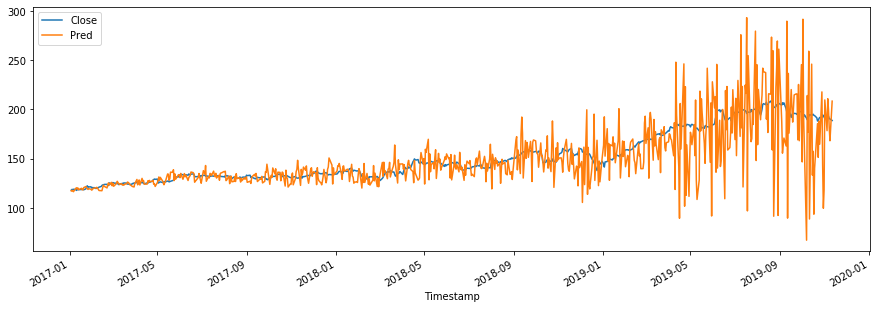

In [51]:
# plot the first model (least training data) by sampling every 30th prediction (step)

first = []
for i in np.arange(0,len(X_test),step):
    first.append(pred_dict[0][i]['Pred'])
#first

#unravel the array to plot the prediction over the actual
first_pred = np.concatenate(first).ravel().tolist()
#len(first_pred)
#first_pred

first_results = pd.DataFrame(base_test) #base_test[step:]
first_results = first_results[:len(first_pred)]
#len(results)

first_results['Pred'] = first_pred

first_results.plot(figsize=(15,5))

In [52]:
#Total Error for the Walk Fowrard
total_MAE = metrics.mean_absolute_error(first_results['Close'], first_results['Pred'])
total_RMSE = metrics.mean_squared_error(first_results['Close'], first_results['Pred'])

print('Aggregate Error for the Walk Forward Validation:')
print('Mean Absolute Error:',total_MAE)
print('Mean Squared Error:',total_RMSE)

Aggregate Error for the Walk Forward Validation:
Mean Absolute Error: 13.985677882859973
Mean Squared Error: 569.2636052685913


In [53]:
first_results.corr(method='pearson')

,Close,Pred
Close,1.000000,0.678443
Pred,0.678443,1.000000


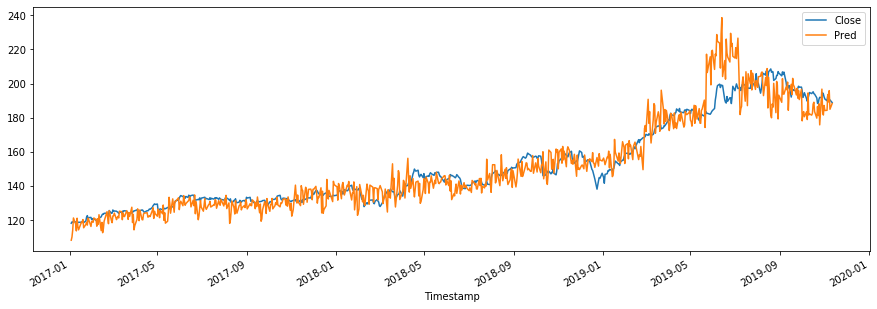

In [54]:
# plot the last model (most training data) by sampling every 30th prediction (step)

last = []
for i in np.arange(0,len(X_test),step):
    last.append(pred_dict[max(pred_dict)][i]['Pred'])
#first

#unravel the array to plot the prediction over the actual
last_pred = np.concatenate(last).ravel().tolist()
#len(first_pred)
#first_pred

last_results = pd.DataFrame(base_test) #base_test[step:]
last_results = last_results[:len(last_pred)]
#len(last_results)

last_results['Pred'] = last_pred

last_results.plot(figsize=(15,5))

In [55]:
#Total Error for the Walk Fowrard
total_MAE = metrics.mean_absolute_error(last_results['Close'], last_results['Pred'])
total_RMSE = metrics.mean_squared_error(last_results['Close'], last_results['Pred'])

print('Aggregate Error for the Walk Forward Validation:')
print('Mean Absolute Error:',total_MAE)
print('Mean Squared Error:',total_RMSE)

Aggregate Error for the Walk Forward Validation:
Mean Absolute Error: 6.0668943142361105
Mean Squared Error: 74.59874830412107


In [56]:
last_results.corr(method='pearson')

,Close,Pred
Close,1.000000,0.950112
Pred,0.950112,1.000000


Now lets take a look at the MAE and RMSE for each run over X_test

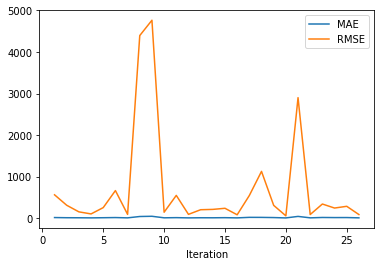

In [57]:
b = pd.DataFrame.from_records(errors, columns=['Iteration', 'MAE', 'RMSE'])
b.plot(x='Iteration', y=['MAE','RMSE'])

In [58]:
#one = pred_dict[0][0]
#two = pred_dict[0][1]
#three = one.append(two, ignore_index=True)
#three.head(5)

In [59]:
#sample the first models predicitons to see the error by forecast day

first_error = pred_dict[0][0]

for i in np.arange(1,len(X_test),step):
    two = pd.DataFrame(pred_dict[0][i])
    three = first_error.append(two, ignore_index=True)
    first_error = three

In [60]:
#first_error.head(5)

In [61]:
#combine all the dfs in the pred_dict dictionary

combined = first_error
#combined.head(60)
#combined = combined[0:len(pred)]
combined['Actual'] = base_test.values[0:len(combined)]
#len(combined)
#combined.head(5)

In [62]:
#combined[combined.Day == 1]

In [63]:
#calculate our the error by day in the forecast

error_by_day = list()

for i in range(1,31):
    df = combined[combined.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    error_by_day.append(error)

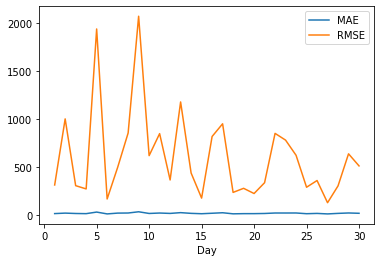

In [64]:
a = pd.DataFrame.from_records(error_by_day, columns=['Day', 'MAE', 'RMSE'])
a.plot(x='Day', y=['MAE','RMSE'])

Discuss the differences in MAE and RMSE

In [65]:
#sample the last models predicitons to see the error by forecast day

last_error = pred_dict[0][max(pred_dict)]

for i in np.arange(1,len(X_test),step):
    two = pd.DataFrame(pred_dict[0][i])
    three = last_error.append(two, ignore_index=True)
    first_error = three

In [66]:
#first_error.head(5)

In [67]:
#combine all the dfs in the pred_dict dictionary

combined = last_error
#combined.head(60)
#combined = combined[0:len(pred)]
combined['Actual'] = base_test.values[0:len(combined)]
#len(combined)
#combined.head(5)

In [68]:
#combined[combined.Day == 1]

In [69]:
#calculate our the error by day in the forecast

error_by_day = list()

for i in range(1,31):
    df = combined[combined.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    error_by_day.append(error)

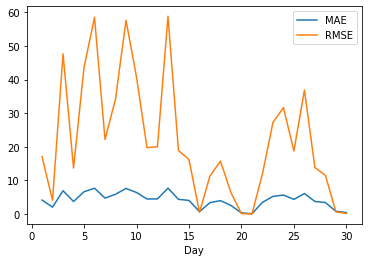

In [70]:
a = pd.DataFrame.from_records(error_by_day, columns=['Day', 'MAE', 'RMSE'])
a.plot(x='Day', y=['MAE','RMSE'])

Hmmm. Model performance is garbage, especially towards the end. I believe I need to retrain at each step.
* Other thing
* Other thing
* Other things